<a href="https://colab.research.google.com/github/asalunai/pesc_mcmc_2020/blob/master/lista_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probabilidade e Estatistica para Aprendizado de Máquina - 2020/1

# Lista 4

Aluna: Ana Luísa Cruz

---

In [1]:
# Apenas se executado no Google Colaboratory
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Instala a versão mais recentes das bibliotecas utilizadas
!pip install seaborn==0.11.
!pip install scipy==1.5.2

In [3]:
# caminhos dos arquivos de dados
dia_casos = '/content/drive/My Drive/COS868 - Probabilidade e Estatística para Aprendizado de Máquina/TrabFinal/casos-novos-ppt.csv'
dia_obito = '/content/drive/My Drive/COS868 - Probabilidade e Estatística para Aprendizado de Máquina/TrabFinal/bitos-novos-ppt.csv'
acm_casos = '/content/drive/My Drive/COS868 - Probabilidade e Estatística para Aprendizado de Máquina/TrabFinal/casos-acumulados-ppt.csv'
acm_obito = '/content/drive/My Drive/COS868 - Probabilidade e Estatística para Aprendizado de Máquina/TrabFinal/bitos-acumulados-ppt.csv'

In [4]:
import pandas as pd
import numpy as np

from scipy.stats import geom, expon, norm, chisquare, ks_1samp

from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.gofplots import qqplot_2samples
from statsmodels.graphics.gofplots import ProbPlot

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', 
        style='ticks', 
        palette='Set2', 
        font='serif', 
        font_scale=1.5, 
        color_codes=True, 
        rc={'figure.figsize':(14,6)})

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Dados

Os estados escolhidos para esse estudo são: Amapá e Tocantins.

Serão avaliados os casos e óbitos diários e acumulados para ambos os estados. 

In [5]:
# Ler os dados como Pandas Dataframes:
df_dia_casos = pd.read_csv(dia_casos, sep=';')
df_dia_obito = pd.read_csv(dia_obito, sep=';')
df_acm_casos = pd.read_csv(acm_casos, sep=';')
df_acm_obito = pd.read_csv(acm_obito, sep=';')

## 1. Estatísticas preliminares

Abaixo, são pltadas as séries temporais de cada uma das VAs escolhidas.



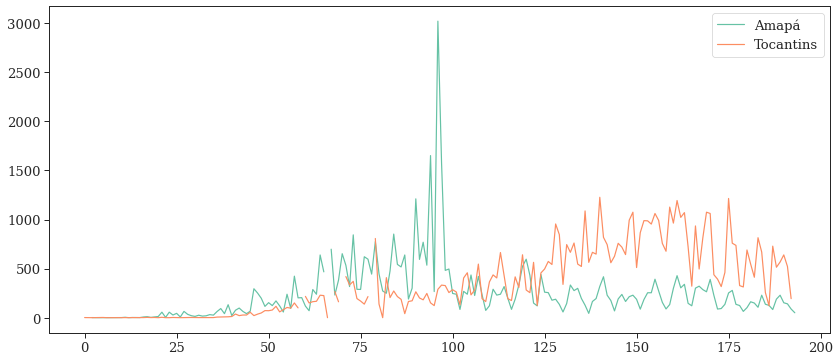

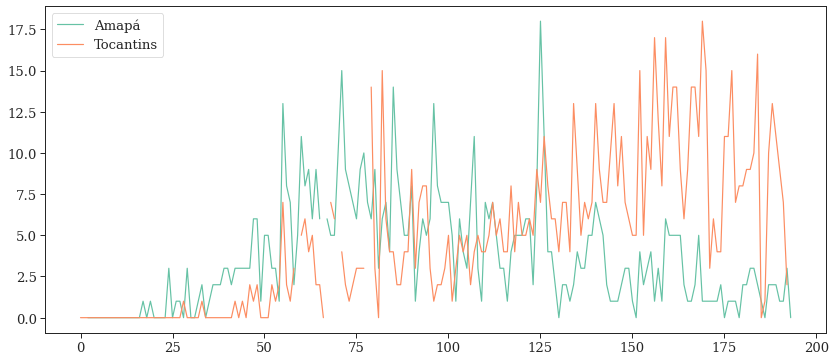

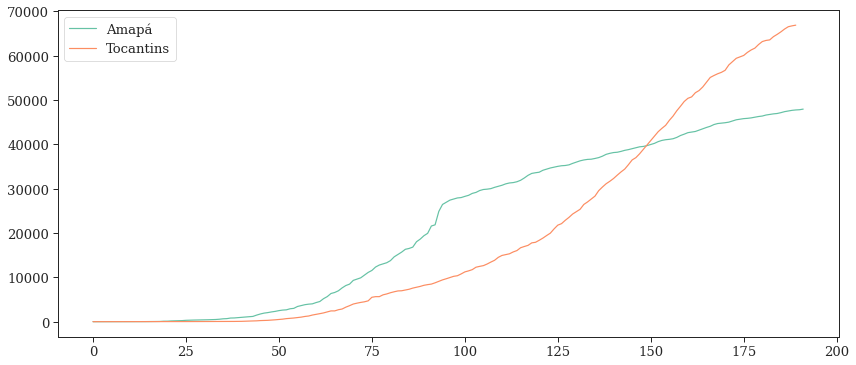

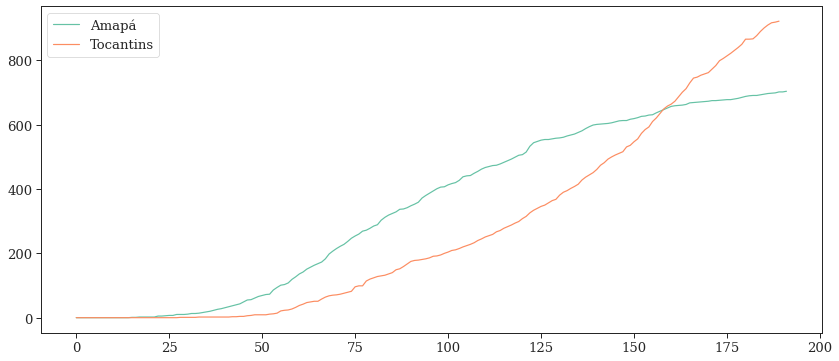

In [6]:
# Plota as séries temporais
df_dia_casos.plot()
df_dia_obito.plot()
df_acm_casos.plot()
df_acm_obito.plot()

Abaixo, estão ilustrados os histogramas e os bloxplots, assim como as médias e desvios padrão.

Para definir a quantidade de bins no histograma, foi utilizado o método de Sturges da biblioteca Numpy.

https://numpy.org/devdocs/reference/generated/numpy.histogram_bin_edges.html


In [7]:
def plt_hb(df, titulo):
  estados = ['Amapá', 'Tocantins']
  fig, sub = plt.subplots(1, 3)
  plt.subplots_adjust(wspace=0.4, hspace=0.4)
  for est, ax in zip(estados, sub.flatten()):
    sns.histplot(data=df, x=est, bins='sturges', stat="count", element="step", ax=ax)
    media, desvp = [df[est].mean(), df[est].std()]
    ax.annotate('Média = '+str("{:.2f}".format(media)), xy=(0.10, 0.95), xycoords='axes fraction')
    ax.annotate('DesvP = '+str("{:.2f}".format(desvp)), xy=(0.10, 0.90), xycoords='axes fraction')
  sub[2] = sns.boxplot(data=df)
  fig.suptitle('Histograma e Boxplot - ' + titulo)
  plt.show()

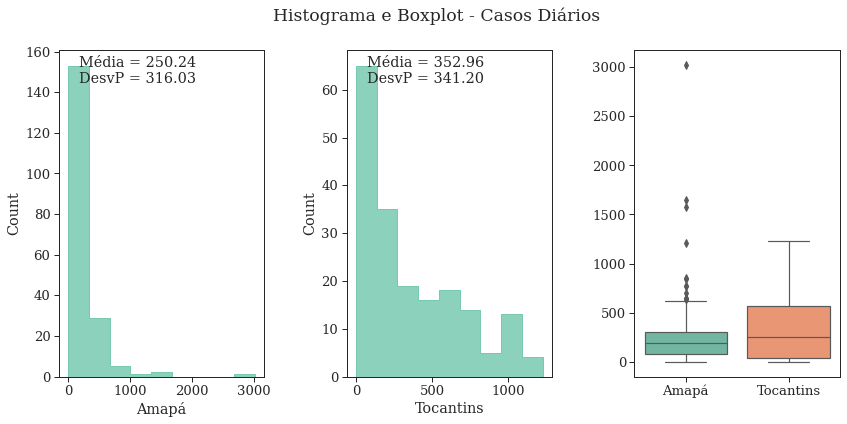

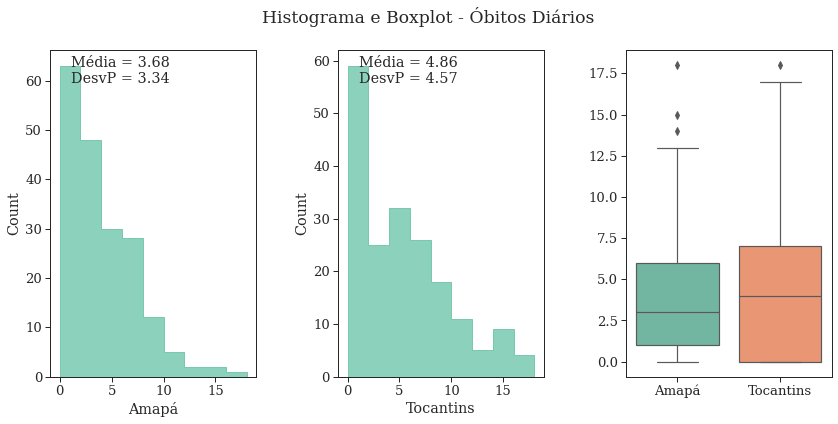

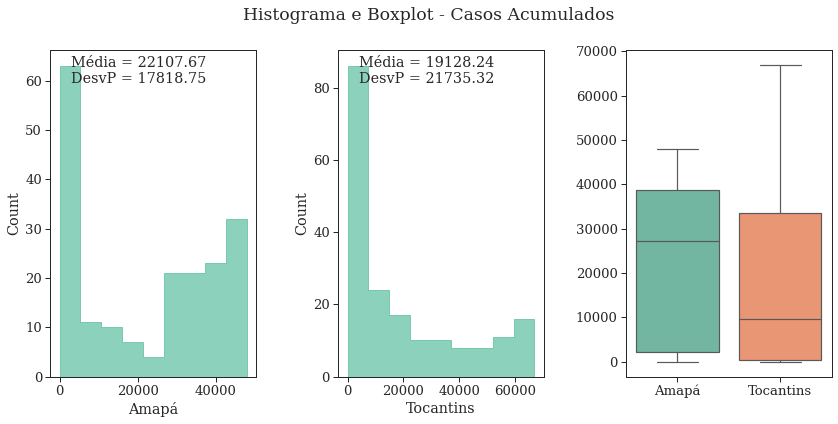

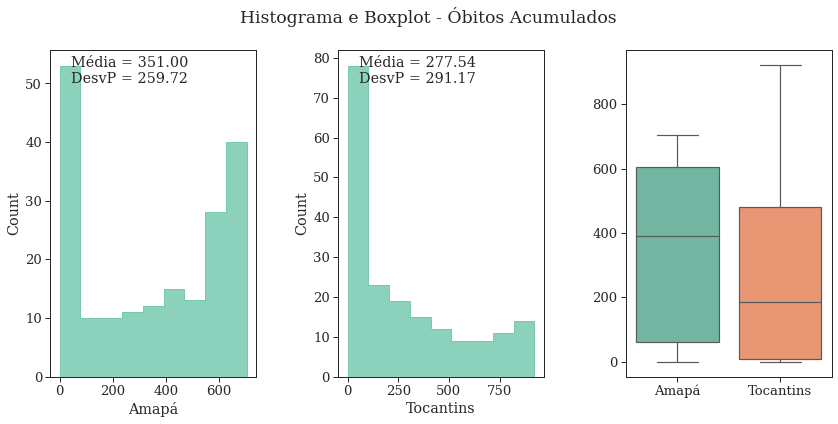

In [8]:
# Plota Histogramas e Boxplots
plt_hb(df_dia_casos, 'Casos Diários')
plt_hb(df_dia_obito, 'Óbitos Diários')
plt_hb(df_acm_casos, 'Casos Acumulados')
plt_hb(df_acm_obito, 'Óbitos Acumulados')

## 2. MLE

Para o MLE, foi utilizado a bibliotaca Scipy, que já tem o método implementado. Exceto para a distribuição geométrica, cujo estimador é dado como $\hat p = \frac{1}{\bar X}$.


In [9]:
def plota(df, dist, ndist, param, ax, x_vars, tipo, p_val=0.):
  if tipo=='cdf':
    sns.histplot(data=df, bins='sturges', cumulative=True, stat="density", element="step", fill=False, ax=ax)
    sns.histplot(data=x_vars, bins=1000, cumulative=True, stat="density", element="step", fill=False, ax=ax)
    ax.set_title(ndist)
    ax.set_xlim(-1., df.max())
  elif tipo=='qqplot':
    if dist=='geom':
      qqplot_2samples(ProbPlot(df), ProbPlot(x_vars), line='45', ax=ax)
      color = ['red' if p_val < 0.05 else 'blue'][0]
      ax.annotate('Chi-Square p = '+str("{:.4f}".format(p_val)), xy=(0.10, 0.95), xycoords='axes fraction', color=color)
      print('Chi-square test p values = ', p_val)
    else:
      qqplot(df, dist=dist, fit=True, line="45", ax=ax) #,  loc=param[-2], scale=param[-1], ax=ax, line="45", fit=False, distargs=param[0])
      color = ['red' if p_val < 0.05 else 'blue'][0]
      ax.annotate('KS test p = '+str("{:.4f}".format(p_val)), xy=(0.10, 0.95), xycoords='axes fraction', color=color)
    ax.set_title(ndist)
  return ax

In [10]:
def final(df, titulo, tipo):

  df[df == 0.] = np.nan
  df.dropna(inplace=True)
  
  fig, sub = plt.subplots(1, 3)
  plt.subplots_adjust(wspace=0.4, hspace=0.4)

  distribuicoes = ['geom', 'expon', 'norm']
  dist_nomes = ['Geométrica', 'Exponencial', 'Normal']

  for dist, ndist, ax in zip(distribuicoes, dist_nomes, sub.flatten()):

    if dist == 'geom':
      param = 1/df.mean()
      x_vars = geom.rvs(param, loc=0, size=1000)
      xtest = geom.rvs(param, loc=0, size=len(df))
      G, p_val = chisquare(df, f_exp=xtest)
      plota(df, dist, ndist, param, ax, x_vars, tipo, p_val)

    if dist == 'expon':
      param = (expon.fit(df, loc=0, optimizer ="MLE"))
      x_vars = expon.rvs(param[-2], param[-1], size=1000)
      D, p_val = ks_1samp(df, expon.cdf, args=param)
      plota(df, dist, ndist, param, ax, x_vars, tipo, p_val)
      
    elif dist == 'norm':
      param = (norm.fit(df, loc=0, optimizer ="MLE"))
      x_vars = norm.rvs(param[-2], param[-1], size=1000)
      D, p_val = ks_1samp(df, norm.cdf, args=param)
      plota(df, dist, ndist, param, ax, x_vars, tipo)

  fig.suptitle(titulo)
  plt.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


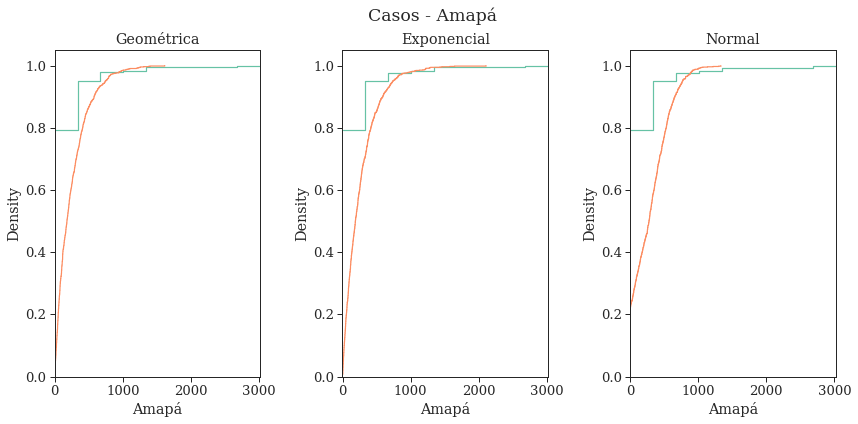

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


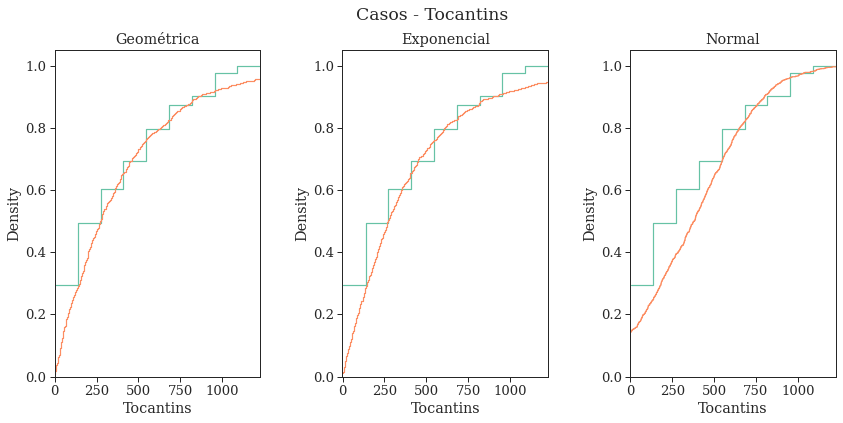

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


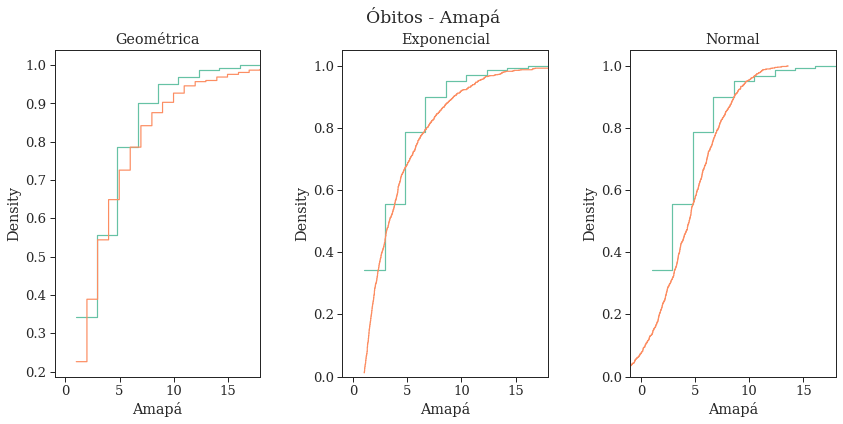

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


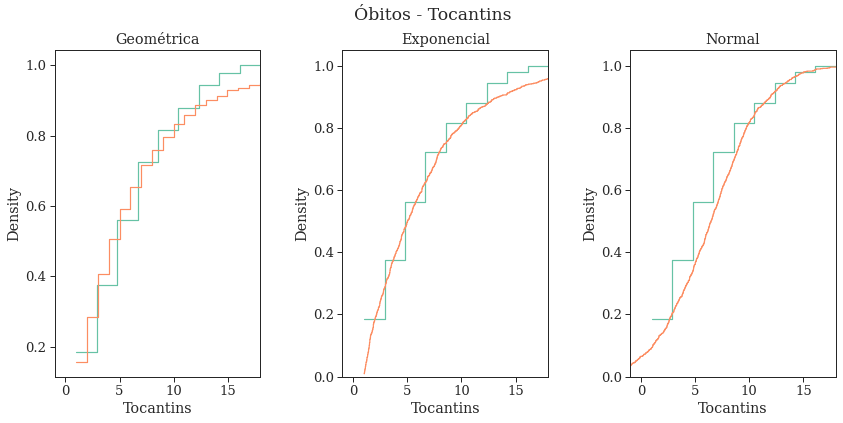

In [11]:
final(df_dia_casos['Amapá'], 'Casos - Amapá', 'cdf')
final(df_dia_casos['Tocantins'], 'Casos - Tocantins', 'cdf')
final(df_dia_obito['Amapá'], 'Óbitos - Amapá', 'cdf')
final(df_dia_obito['Tocantins'], 'Óbitos - Tocantins', 'cdf')

## 3. e 5. Probability plot e Chi-Square test

Foram utilizados os testes de *goodnes of fit* Chi-Square para a distribuição Geométrica e Kolmogorov-Smirnov para as distribuições normal e exponencial.

Nos gráficos abaixo, os valores de p dos testes estão nos respectivos gráficos. Valores em vermelho (azul) indicam que a Hipótese nula foi rejeitada (aceita).

É possivel ver que a Hipótese nula foi rejeitada para todas as V.A.s. e que, portanto, provavelmente nenhuma V.A. apresenta distribuição geométrica, normal ou exponencial.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Chi-square test p values =  0.0


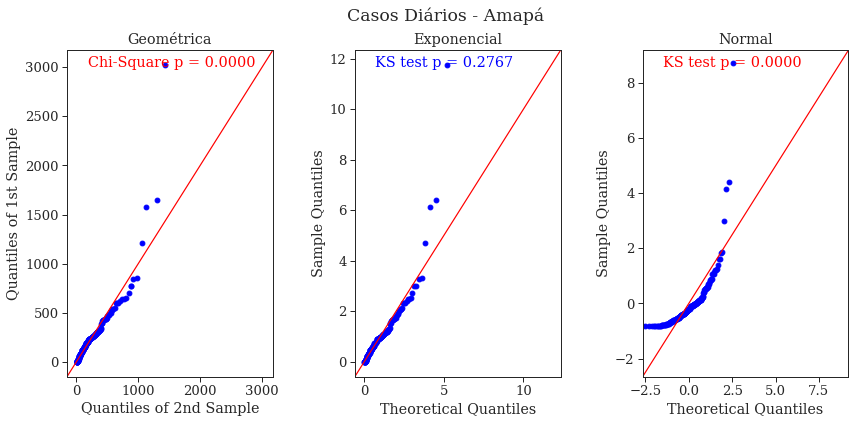

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Chi-square test p values =  0.0


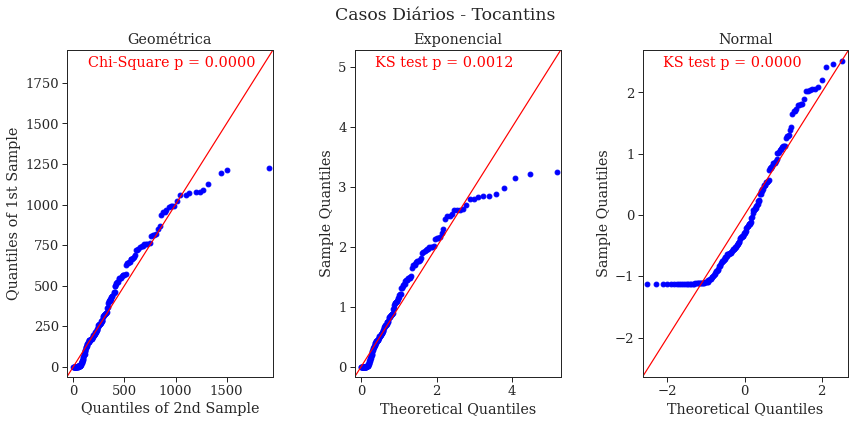

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Chi-square test p values =  3.8662605724752603e-187


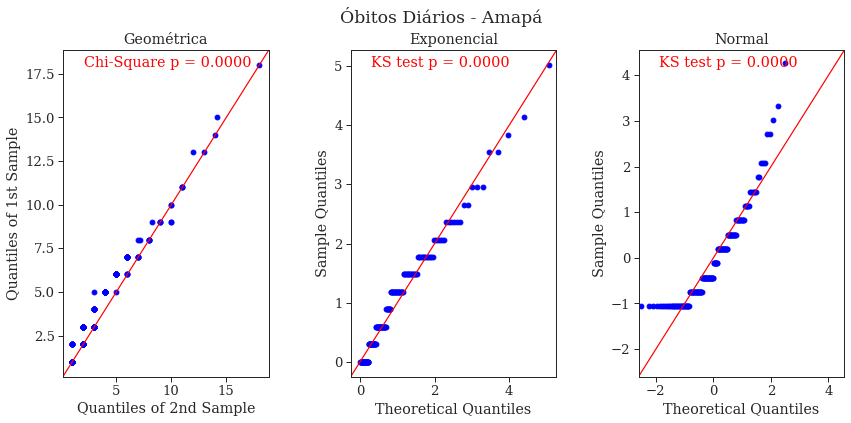

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Chi-square test p values =  0.0


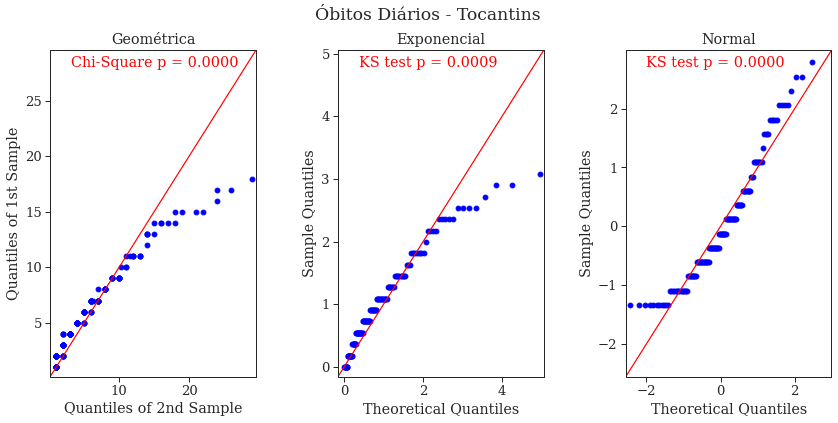

In [12]:
final(df_dia_casos['Amapá'], 'Casos Diários - Amapá', 'qqplot')
final(df_dia_casos['Tocantins'], 'Casos Diários - Tocantins', 'qqplot')
final(df_dia_obito['Amapá'], 'Óbitos Diários - Amapá', 'qqplot')
final(df_dia_obito['Tocantins'], 'Óbitos Diários - Tocantins', 'qqplot')

## 4. Teste Não-Paramétrico

Para o teste de hipótese, foi escolhido o teste não-paramétrico de Mann-Whitney U. 

A formulação geral assume que:

* Todas as observações de ambos os grupos são independentes umas das outras.
* As respostas são ordinais (ou seja, pode-se pelo menos dizer, de quaisquer duas observações, qual é a maior).
* A hipótese nula $H_0$: as distribuições de ambas as populações são iguais.
* A hipótese alternativa $H_1$: as distribuições não são iguais.

Esse teste não assume que as distribuições são normais e costuma ser calculado como bi-caudal (de acordo com a documentação do Scipy: alternative='two-sided').



In [13]:
from scipy.stats import mannwhitneyu

def non_par_tests(data1,data2):
  # Mann-Whitney U Test
  stat, p_val = mannwhitneyu(data1, data2, alternative='two-sided')
  teste = ['Aceita H0' if p_val > 0.05 else 'Rejeita H0'][0]
  print(' Mann-Whitney U = ', "{:.4f}".format(p_val), teste)
  return

In [14]:
print('\n Casos Diários - Amapá vs. Tocantins')
non_par_tests(df_dia_casos['Amapá'],df_dia_casos['Tocantins'])
print('\n Óbitos Diários - Amapá vs. Tocantins')
non_par_tests(df_dia_obito['Amapá'],df_dia_obito['Tocantins'])
print('\n Casos Acumulados - Amapá vs. Tocantins')
non_par_tests(df_acm_casos['Amapá'],df_acm_casos['Tocantins'])
print('\n Óbitos Acumulados - Amapá vs. Tocantins')
non_par_tests(df_acm_obito['Amapá'],df_acm_obito['Tocantins'])


 Casos Diários - Amapá vs. Tocantins
 Mann-Whitney U =  0.0004 Rejeita H0

 Óbitos Diários - Amapá vs. Tocantins
 Mann-Whitney U =  0.0000 Rejeita H0

 Casos Acumulados - Amapá vs. Tocantins
 Mann-Whitney U =  0.0625 Aceita H0

 Óbitos Acumulados - Amapá vs. Tocantins
 Mann-Whitney U =  0.0053 Rejeita H0
